
# Q1: Copulas

In this section we demonstrate two ways to model the dependency structure among non–normally distributed variables using copulas.

**A copula** is a function that joins one–dimensional marginal distributions to form a multivariate distribution. In practice, one typically:

1. Transforms each variable to a common scale (e.g. via its cumulative distribution function (CDF)) so that all marginals become uniform (or, after further transformation, standard normal).
2. Models the joint dependency using a multivariate distribution (often a Gaussian with an LKJ–prior on the correlation matrix).

We first generate synthetic non–normal data from three different distributions (Gamma, Exponential, and Chi–Squared) using a latent multivariate normal structure.

Then we implement:

1. A **one–pass approach** where the transformation from the original likelihoods to the Gaussian scale is performed within the model.
2. A **two–pass approach** where we first transform the data using the empirical CDF and then model the joint dependence.


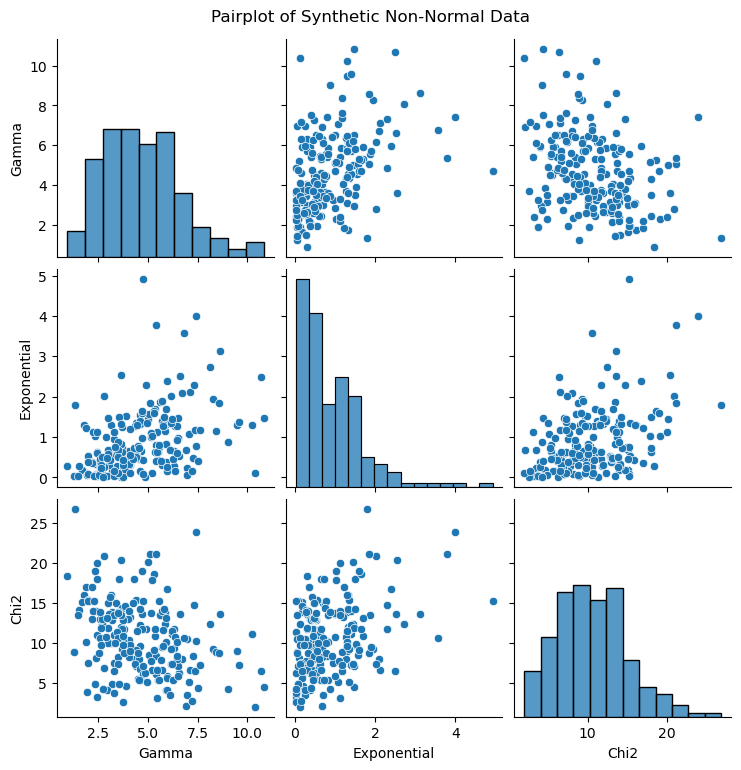

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
np.random.seed(42)

# --- Synthetic Data Generation for Copula Example ---
p = 3      # three variables
n = 200    # number of observations

# Define a latent correlation matrix (for the underlying multivariate normal)
corr = np.array([[1.0, 0.5, -0.3],
                 [0.5, 1.0,  0.4],
                 [-0.3, 0.4, 1.0]])

latent = stats.multivariate_normal(mean=[0, 0, 0], cov=corr).rvs(size=n)

# Transform each latent variable into a non–normal marginal:
# - Column 0: Gamma (shape=2)
# - Column 1: Exponential (scale=1)
# # - Column 2: Chi–Squared (df=3)
# data = np.empty_like(latent)
# data[:, 0] = stats.gamma(a=2).ppf(stats.norm.cdf(latent[:, 0]))
# data[:, 1] = stats.expon(scale=1).ppf(stats.norm.cdf(latent[:, 1]))
# data[:, 2] = stats.chi2(df=3).ppf(stats.norm.cdf(latent[:, 2]))
from scipy import stats
data = np.empty_like(latent)
data[:,0] = stats.gamma(a=5).ppf(stats.norm.cdf(latent[:,0]))
data[:,1] = stats.expon(scale=1).ppf(stats.norm.cdf(latent[:,1]))
data[:,2] = stats.chi2(df=10).ppf(stats.norm.cdf(latent[:,2]))

# Create a DataFrame and visualize pairwise relationships
df = pd.DataFrame(data, columns=["Gamma", "Exponential", "Chi2"])
sns.pairplot(df)
plt.suptitle("Pairplot of Synthetic Non-Normal Data", y=1.02)
plt.show()


### Q1 – One–Pass Copula Approach

In the one–pass approach the marginal likelihoods (e.g. Gamma, Exponential, Chi–Squared) are modeled directly and then transformed within the model to a common (Gaussian) scale using the inverse CDF (icdf) of the standard normal. Finally, a multivariate normal likelihood (with an LKJ–prior on the correlation matrix) is used to capture the dependency among the transformed variables.

**Note:** The transformation in the model uses the built–in functions (e.g. `pm.Gamma.logcdf` and `pm.Normal.icdf`). In practice this approach couples the marginal estimation with the dependency model.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p0, p1, R]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


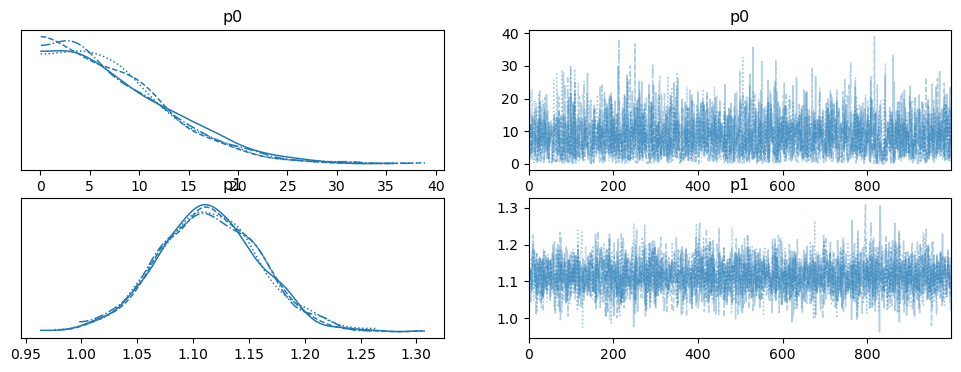

In [13]:
import pymc as pm
import arviz as az
with pm.Model() as copula_one_pass_corrected:
    # --- Gamma marginal for variable 0 ---
    # Use Gamma with α=5, β=1 (scale=1)
    p0 = pm.HalfNormal('p0', sigma=10)
    y0 = pm.Gamma('y0', alpha=5, beta=1, observed=data[:, 0])
    y0_trans = pm.Deterministic('y0_trans',
        pm.Normal.icdf(pm.math.exp(pm.Gamma.logcdf(y0, alpha=5, scale=1)), mu=0, sigma=1))
    
    # --- Exponential marginal for variable 1 ---
    p1 = pm.HalfNormal('p1', sigma=10)
    y1 = pm.Exponential('y1', lam=p1, observed=data[:, 1])
    y1_trans = pm.Deterministic('y1_trans',
        pm.Normal.icdf(pm.math.exp(pm.Exponential.logcdf(y1, mu=p1)), mu=0, sigma=1))
    
    # --- Chi–Squared marginal for variable 2 ---
    # ChiSquared(ν=10) is equivalent to Gamma(α=5, β=0.5) so we use scale=2.
    y2 = pm.ChiSquared('y2', nu=10, observed=data[:, 2])
    y2_trans = pm.Deterministic('y2_trans',
        pm.Normal.icdf(pm.math.exp(pm.Gamma.logcdf(y2, alpha=5, scale=2)), mu=0, sigma=1))
    
    # --- Joint dependency ---
    # Concatenate the transformed variables (n x 3)
    y_stack = pm.math.concatenate([y0_trans[:, None], y1_trans[:, None], y2_trans[:, None]], axis=1)
    
    # LKJ prior on the Cholesky factor with an Exponential prior for standard deviations
    L, R, _ = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                sd_dist=pm.Exponential.dist(1.0),
                                compute_corr=True)
    
    # Instead of using 'observed', we add the multivariate likelihood as a Potential
    pm.Potential("MVNeval", pm.logp(pm.MvNormal.dist(mu=np.zeros(3), chol=L), y_stack))
    
    trace_one_pass_corrected = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)
    
az.plot_trace(trace_one_pass_corrected, var_names=["p0", "p1"])
plt.show()

### Q1 – Two–Pass Copula Approach

In the two–pass approach we decouple the estimation:

1. **First pass:** Transform each observed variable to a common (Gaussian) scale using the empirical CDF.
2. **Second pass:** Use the transformed data to model the dependency structure via a multivariate normal with an LKJ–prior.

This separation can simplify the modeling and makes it easier to plug in different marginal models (e.g., arbitrary GLMs) for each variable.

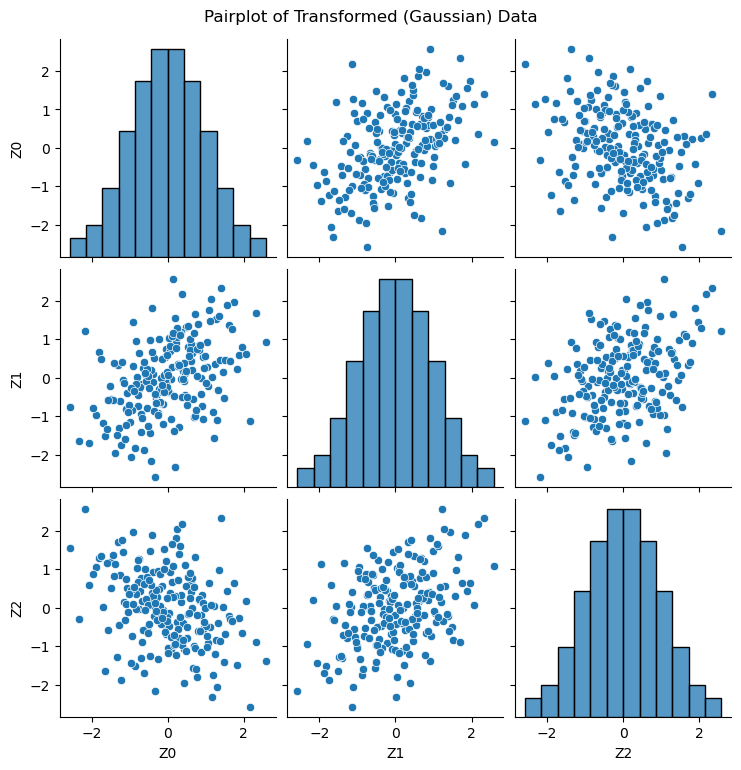

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [R]


Output()

/Users/aryanmisra/miniforge3/envs/pymc_env/lib/python3.12/site-packages/pytensor/compile/function/types.py:992: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Plotting variables: ['R', 'R_stds']


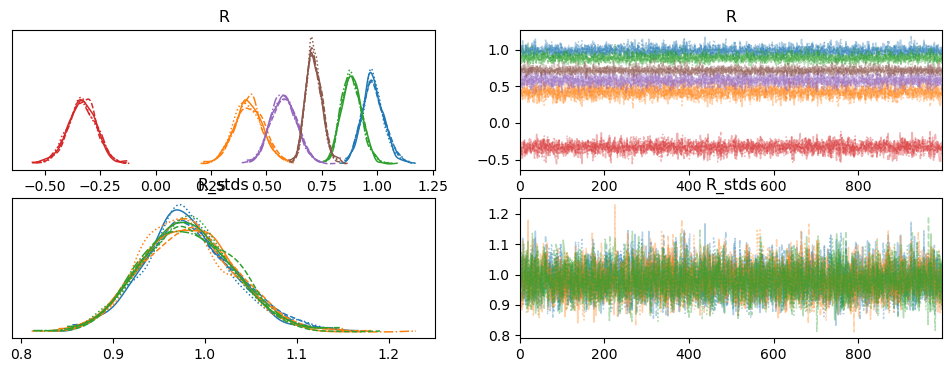

In [16]:
from scipy.stats import rankdata, norm

def empirical_transform(x):
    """Compute an empirical CDF transformation and then apply the inverse CDF of the standard normal."""
    ranks = rankdata(x) / (len(x) + 1)
    return norm.ppf(ranks)

# Apply the transformation to each column
z0 = empirical_transform(data[:, 0])
z1 = empirical_transform(data[:, 1])
z2 = empirical_transform(data[:, 2])
z_stack = np.column_stack([z0, z1, z2])

# Visualize the transformed data
df_z = pd.DataFrame(z_stack, columns=["Z0", "Z1", "Z2"])
sns.pairplot(df_z)
plt.suptitle("Pairplot of Transformed (Gaussian) Data", y=1.02)
plt.show()

with pm.Model() as copula_two_pass:
    # Set up the LKJ prior on the Cholesky factor.
    L2, R2, _ = pm.LKJCholeskyCov("R", n=3, eta=2.0,
                                   sd_dist=pm.Exponential.dist(1.0),
                                   compute_corr=True)
    # Use the transformed data as observed for the multivariate normal likelihood
    pm.MvNormal("joint", mu=np.zeros(3), chol=L2, observed=z_stack)
    
    trace_two_pass = pm.sample(1000, tune=1000, target_accept=0.95, return_inferencedata=True)
    
trace_vars = list(trace_two_pass.posterior.data_vars.keys())
# Exclude R_corr if present
filtered_vars = [v for v in trace_vars if v != "R_corr"]

print("Plotting variables:", filtered_vars)

# Now plot the trace for the filtered variables
az.plot_trace(trace_two_pass, var_names=filtered_vars)
plt.show()

### Q1 Summary

- **Copulas** separate the modeling of marginals from the dependency structure.
- The **one–pass approach** models the marginals (e.g. Gamma, Exponential, Chi–Squared) and performs the transformation within the model.
- The **two–pass approach** first transforms the data (e.g. using the empirical CDF) and then models the joint dependency.

**Application to Multivariate GLMs:**  
For arbitrary multivariate GLM regressions, you can:

1. Specify a GLM for each outcome (using appropriate likelihoods for each marginal).
2. Transform the fitted values to a common scale.
3. Use a copula (e.g., a multivariate normal with an LKJ–prior) to capture the joint dependency.

This allows you to model responses of different types (binary, count, continuous, etc.) in a unified way.

# Q2: Variable Selection Using Spike and Slab Priors

In this section we perform multivariate regression on synthetic data using two methods:

1. **Spike and Slab Priors:**  
   Each regression coefficient is modeled as a product of a binary indicator (the "spike" that may set it to zero) and a diffuse normal ("slab") that allows non–zero values. This produces a sparse solution, effectively selecting variables.

2. **Diffuse Normal Priors:**  
   Here we simply place a diffuse (e.g., N(0,10)) prior on all coefficients, similar to L2 regularization. All predictors remain in the model.

We compare the posterior estimates of the regression coefficients against the true coefficients.

In [17]:
# --- Synthetic Data Generation for Regression ---
n = 100   # number of observations
p = 5     # number of predictors

# True sparse coefficients (only a subset are non-zero)
beta_true = np.array([2.0, 0.0, -3.0, 0.0, 0.5])
X = np.random.normal(0, 1, size=(n, p))
sigma_true = 1.0
y = X.dot(beta_true) + np.random.normal(0, sigma_true, size=n)

print("True coefficients:", beta_true)

True coefficients: [ 2.   0.  -3.   0.   0.5]


### Q2 – Spike and Slab Regression Model
 
In the spike and slab model we: 
- Define a global inclusion probability (here via a Beta prior).
- Introduce a binary indicator $\gamma_j$ (modeled via a Bernoulli) for each predictor.
- Multiply a diffuse "slab" (Normal prior) by the indicator to form the coefficient.

This approach promotes sparsity by effectively “turning off” predictors when $\gamma_j$ is 0.

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_incl, slab, sigma]
>BinaryGibbsMetropolis: [gamma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 32 seconds.
/Users/aryanmisra/miniforge3/envs/pymc_env/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


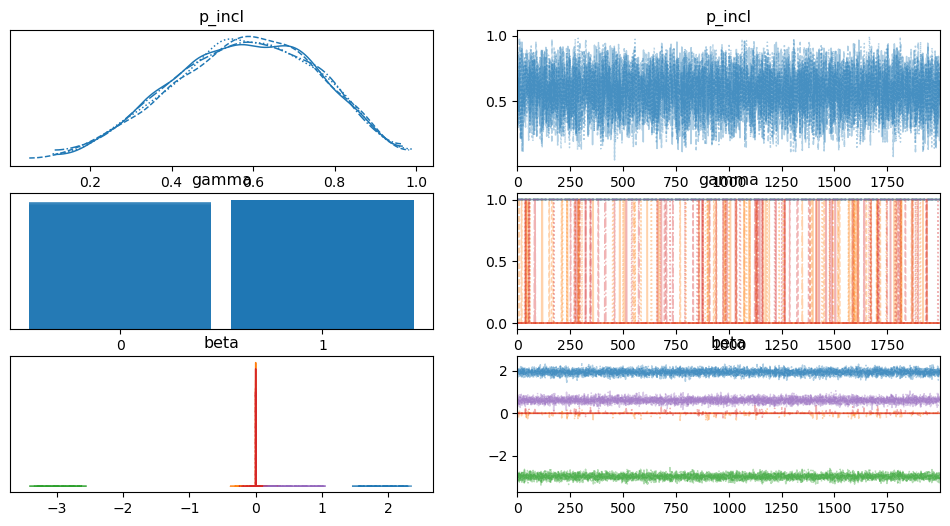

In [20]:
with pm.Model() as spike_slab_model:
    # Global inclusion probability (could be common or separate for each predictor)
    p_incl = pm.Beta('p_incl', alpha=1, beta=1)
    
    # Inclusion indicators for each predictor
    gamma = pm.Bernoulli('gamma', p=p_incl, shape=p)
    
    # Slab: diffuse normal for each predictor
    slab = pm.Normal('slab', mu=0, sigma=10, shape=p)
    
    # Spike and slab prior for regression coefficients
    beta_ss = pm.Deterministic('beta', gamma * slab)
    
    # Likelihood for the regression
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.dot(X, beta_ss)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    trace_ss = pm.sample(2000, tune=2000, target_accept=0.999, return_inferencedata=True)
    
az.plot_trace(trace_ss, var_names=["p_incl", "gamma", "beta"])
plt.show()

### Q2 – Diffuse (L2–style) Regression Model

Here we simply use a diffuse normal prior for all coefficients. This does not perform variable selection explicitly but shrinks coefficients toward zero.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1 seconds.


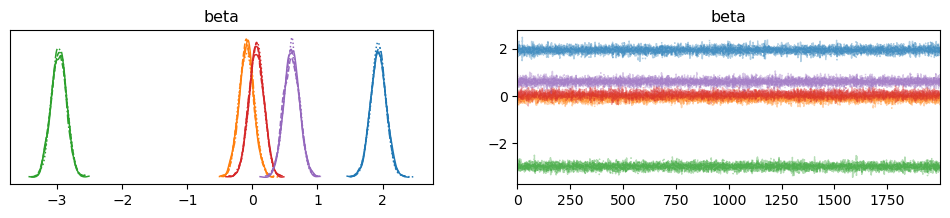

In [21]:
with pm.Model() as diffuse_model:
    beta_diffuse = pm.Normal('beta', mu=0, sigma=10, shape=p)
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.dot(X, beta_diffuse)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    trace_diffuse = pm.sample(2000, tune=2000, target_accept=0.95, return_inferencedata=True)
    
az.plot_trace(trace_diffuse, var_names=["beta"])
plt.show()

### Q2 – Comparing Posterior Estimates

True beta: [ 2.   0.  -3.   0.   0.5]
Spike and Slab posterior mean beta: [ 1.93261160e+00 -2.44432826e-03 -2.97246761e+00  1.49678216e-03
  6.11993022e-01]
Diffuse posterior mean beta: [ 1.93449412 -0.09048079 -2.97603433  0.05970532  0.60264042]


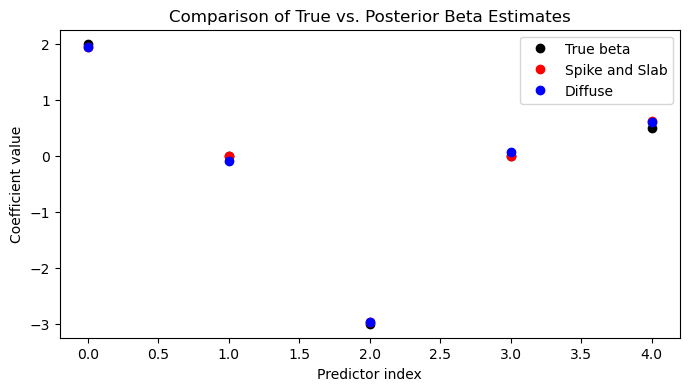

In [22]:
# Compute posterior means for beta in each model
beta_ss_post = trace_ss.posterior["beta"].mean(dim=["chain", "draw"]).values
beta_diffuse_post = trace_diffuse.posterior["beta"].mean(dim=["chain", "draw"]).values

print("True beta:", beta_true)
print("Spike and Slab posterior mean beta:", beta_ss_post)
print("Diffuse posterior mean beta:", beta_diffuse_post)

# Plot the comparison
plt.figure(figsize=(8,4))
plt.plot(beta_true, 'ko', label='True beta')
plt.plot(beta_ss_post, 'ro', label='Spike and Slab')
plt.plot(beta_diffuse_post, 'bo', label='Diffuse')
plt.xlabel("Predictor index")
plt.ylabel("Coefficient value")
plt.title("Comparison of True vs. Posterior Beta Estimates")
plt.legend()
plt.show()

# Q3: Variable Selection Using the Horseshoe Prior

The **horseshoe prior** is a continuous shrinkage prior designed for sparse signals. It is defined by:
 
$$
 \beta_i \sim N(0, \tau^2 \lambda_i^2),\quad \lambda_i \sim \text{Half-Cauchy}(1),\quad \tau \sim \text{Half-Cauchy}(\tau_0)
$$

In this section we use the horseshoe prior for our regression model and compare the posterior estimates to those from the spike and slab model.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, lam, beta, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 22 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


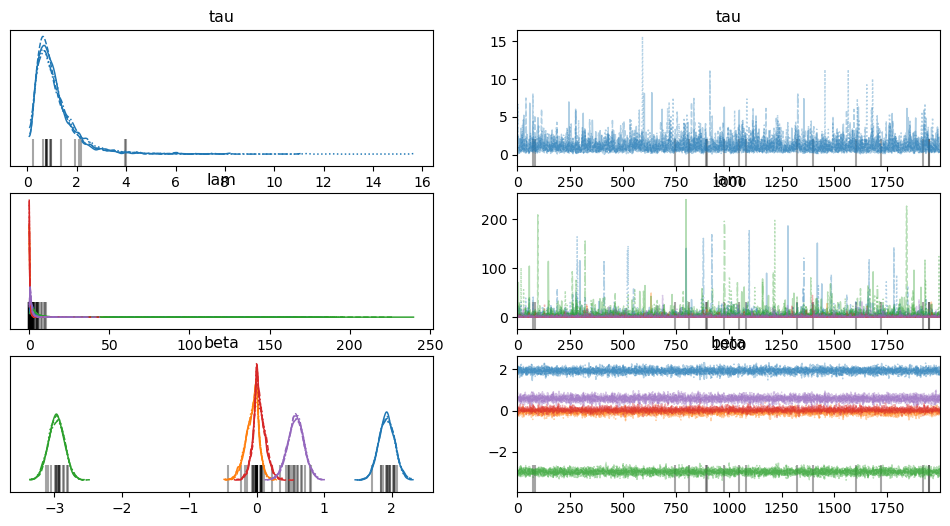

In [27]:
with pm.Model() as horseshoe_model:
    # Global shrinkage parameter
    tau = pm.HalfCauchy('tau', beta=1)
    # Local shrinkage parameters for each predictor
    lam = pm.HalfCauchy('lam', beta=1, shape=p)
    
    # Horseshoe prior for regression coefficients
    beta_hs = pm.Normal('beta', mu=0, sigma=tau * lam, shape=p)
    
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = pm.math.dot(X, beta_hs)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    trace_hs = pm.sample(2000, tune=2000, target_accept=0.99995, return_inferencedata=True)
    
az.plot_trace(trace_hs, var_names=["tau", "lam", "beta"])
plt.show()

### Q3 – Comparing Horseshoe and Spike and Slab Models

True beta: [ 2.   0.  -3.   0.   0.5]
Horseshoe posterior mean beta: [ 1.92787195 -0.06456262 -2.96710338  0.03993438  0.58261744]
Spike and Slab posterior mean beta: [ 1.93261160e+00 -2.44432826e-03 -2.97246761e+00  1.49678216e-03
  6.11993022e-01]


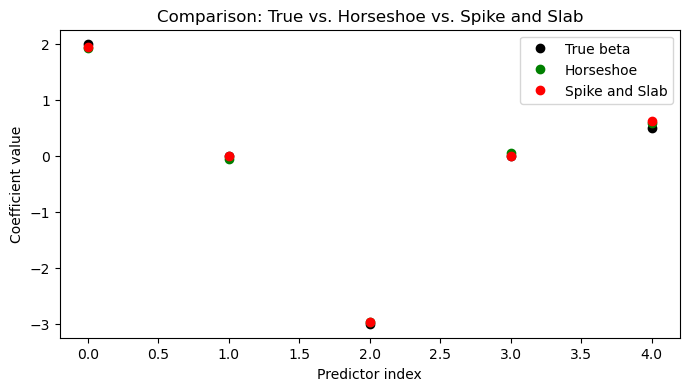

In [28]:
# Compute the posterior mean for beta from the horseshoe model
beta_hs_post = trace_hs.posterior["beta"].mean(dim=["chain", "draw"]).values

print("True beta:", beta_true)
print("Horseshoe posterior mean beta:", beta_hs_post)
print("Spike and Slab posterior mean beta:", beta_ss_post)

# Plot the comparison
plt.figure(figsize=(8,4))
plt.plot(beta_true, 'ko', label='True beta')
plt.plot(beta_hs_post, 'go', label='Horseshoe')
plt.plot(beta_ss_post, 'ro', label='Spike and Slab')
plt.xlabel("Predictor index")
plt.ylabel("Coefficient value")
plt.title("Comparison: True vs. Horseshoe vs. Spike and Slab")
plt.legend()
plt.show()

## Final Summary

**Q1: Copulas**
- A copula separates the marginal distributions from the joint dependency.
- In the **one–pass approach**, the transformation to the Gaussian scale is performed within the model.
- In the **two–pass approach**, the data are first transformed externally (using the empirical CDF) and then modeled.
- This idea can be extended to multivariate GLM regressions where each outcome is modeled separately and then "coupled" via a copula.

**Q2: Variable Selection Using Spike and Slab**
- The spike and slab model uses a binary indicator to "turn off" irrelevant predictors and a diffuse prior for active predictors.
- When compared with a diffuse normal prior (which applies mild L2–regularization), spike and slab provides a sparse solution.

**Q3: Variable Selection Using the Horseshoe Prior**
- The horseshoe prior provides continuous shrinkage, allowing coefficients to be strongly shrunk toward zero unless the data strongly support them.
- Compared to spike and slab, the horseshoe avoids discrete indicator variables while still achieving sparsity.

Together, these methods offer powerful ways to both capture complex dependency structures and perform variable selection in high–dimensional Bayesian models.
